## Graph Convolutional Network and LoDoPaB-CT

In [1]:
import time
start = time.time()

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append("..")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr,compare_ssim, compare_mse
import pydicom
import pydicom.data
from PIL import Image
from numpy import asarray
from torch.nn import MSELoss
from torch.optim import Adam, SGD, Adagrad, Adadelta,RMSprop
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from util import show, plot_images, plot_tensors

In [6]:
plt.rc('figure', figsize = (5,5))

In [8]:
#noisy_image = np.asfarray(noisy_image.pixel_array)


image = Image.open('image/image11.jpg') 
numpydata = asarray(image)
image = img_as_float(numpydata)


noisy_image = Image.open('image/noisy_image11.jpg') 
numpydata = asarray(noisy_image)
noisy_image = img_as_float(numpydata)

# Model

For our model, we use a deep convolutional network.

In [13]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

223104

# Training

In [15]:
losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = np.clip(model(noisy).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            best_psnr = compare_psnr(denoised, image)
            best_images.append(denoised)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

( 0 ) Loss: 	 0.01614 	Val Loss: 	 0.11399
	Model PSNR:  5.22
( 10 ) Loss: 	 0.00092 	Val Loss: 	 0.00216
	Model PSNR:  14.51
( 20 ) Loss: 	 0.00058 	Val Loss: 	 0.00091
	Model PSNR:  19.54
( 30 ) Loss: 	 0.00052 	Val Loss: 	 0.0007
	Model PSNR:  22.06
( 40 ) Loss: 	 0.00051 	Val Loss: 	 0.00065
	Model PSNR:  22.66
( 50 ) Loss: 	 0.00048 	Val Loss: 	 0.00054
	Model PSNR:  24.74
( 60 ) Loss: 	 0.00048 	Val Loss: 	 0.0005
	Model PSNR:  25.84
( 70 ) Loss: 	 0.00048 	Val Loss: 	 0.00048
	Model PSNR:  26.66
( 80 ) Loss: 	 0.00047 	Val Loss: 	 0.00047
	Model PSNR:  27.41
( 90 ) Loss: 	 0.00047 	Val Loss: 	 0.00047
	Model PSNR:  27.33
( 100 ) Loss: 	 0.00047 	Val Loss: 	 0.00047
	Model PSNR:  27.55
( 110 ) Loss: 	 0.00046 	Val Loss: 	 0.00046
	Model PSNR:  28.02
( 120 ) Loss: 	 0.00046 	Val Loss: 	 0.00046
	Model PSNR:  27.82
( 130 ) Loss: 	 0.00047 	Val Loss: 	 0.00046
	Model PSNR:  27.92
( 140 ) Loss: 	 0.00045 	Val Loss: 	 0.00046
	Model PSNR:  28.34
( 150 ) Loss: 	 0.00045 	Val Loss: 	 0.

In [16]:
denoised = best_images[-1]

[]

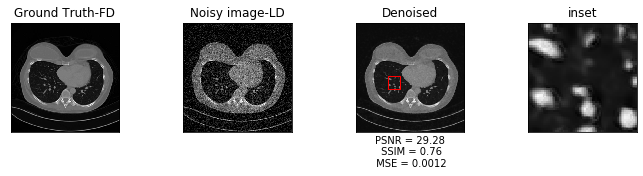

In [17]:
from skimage.measure import compare_psnr,compare_mse
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
fig.tight_layout(pad=3)

ax1.set(title='Ground Truth-FD') # , ylabel='# of medals', xlabel='Country')
ax1.imshow(image, cmap='gray')
ax1.set_yticks([])
ax1.set_xticks([])

ax2.set(title='Noisy image-LD')
ax2.imshow(noisy_image, cmap='gray')
ax2.set_yticks([])
ax2.set_xticks([])

ax3.set(title='Denoised',xLabel='PSNR = ' + str(round(compare_psnr(denoised, image),2)) + 
              '\n SSIM = ' + str(round(compare_ssim(denoised, image),2)) + 
       '\n MSE = ' + str(round(compare_mse(denoised, image),4)))
rect = Rectangle((150,250),60,60, edgecolor='r', facecolor="none")
ax3.imshow(denoised, cmap='gray')
ax3.add_patch(rect)
ax3.set_yticks([])
ax3.set_xticks([])

x1 = 250
x2 = 310
y1 = 150
y2 = 210
get_inset = lambda x: x[x1:x2, y1:y2]
ax4.set(title='inset')
ax4.imshow(get_inset(denoised), cmap='gray')
ax4.set_yticks([])
ax4.set_xticks([])


In [18]:
stop = time.time()
elapsed = stop - start
print(elapsed)

7328.009761810303
